In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Reading the data using pandas dataframe

In [0]:
import pandas as pd
data = pd.read_csv('drive/My Drive/marcari_kaggle_data/train.tsv', sep='\t')
data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


### dropping the data points (rows) with price=0

In [0]:
data = data[data['price'] > 0].reset_index(drop=True)

### Defining functions to be used for creating new features.

In [0]:
def calc_char_len(x): # Calculating the character length of each text data
  try: return len(x)
  except: return 0

def calc_word_len(x): # Calculating the word length of each text data
  try: return len(x.split(' '))
  except: return 0

In [0]:
data['price_log'] = data['price'].apply(lambda x:np.log1p(x)) # creating new feature -> log(1+price)
data['item_description_word_length'] = data['item_description'].apply(lambda x:calc_word_len(x)) # creating new feature -> character length of item_description
data['item_description_char_length'] = data['item_description'].apply(lambda x:calc_char_len(x)) # creating new feature -> word length of item_description
data['log_item_description_word_length'] = data['item_description_word_length'].apply(lambda x:np.log1p(x)) # creating new feature -> log(1 + character length of item_description)
data['log_item_description_char_length'] = data['item_description_char_length'].apply(lambda x:np.log1p(x)) # creating new feature -> log(1 + word length of item_description)
data['name_length'] = data['name'].apply(lambda x:len(x)) # creating new feature -> character length of name_length
# data.head(5)

In [0]:
data['category_name'] = data['category_name'].fillna('no label/no label/no label') # substituting the rows of feature 'category_name' with NaN values with 'no label'

In [0]:
# this is to divide the category_name feature into 3 sub categories
from tqdm import tqdm_notebook
sub_category_1 = []
sub_category_2 = []
sub_category_3 = []
for feature in tqdm_notebook(data['category_name'].values):
  fs = feature.split('/')
  a,b,c = fs[0], fs[1], ' '.join(fs[2:])
  sub_category_1.append(a)
  sub_category_2.append(b)
  sub_category_3.append(c)
data['sub_category_1'] = sub_category_1
data['sub_category_2'] = sub_category_2
data['sub_category_3'] = sub_category_3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [0]:
data['brand_name'] = data['brand_name'].fillna('unknown') # replacing NaN values with 'unknown'
data['item_description'] = data['item_description'].fillna('') # replacing NaN values with ''

In [0]:
data.dtypes

train_id                              int64
name                                 object
item_condition_id                     int64
category_name                        object
brand_name                           object
price                               float64
shipping                              int64
item_description                     object
price_log                           float64
item_description_word_length          int64
item_description_char_length          int64
log_item_description_word_length    float64
log_item_description_char_length    float64
name_length                           int64
sub_category_1                       object
sub_category_2                       object
sub_category_3                       object
dtype: object

In [0]:
data.shape

(1481661, 17)

In [0]:
# let's check the dataframe after adding new features
data.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,price_log,item_description_word_length,item_description_char_length,log_item_description_word_length,log_item_description_char_length,name_length,sub_category_1,sub_category_2,sub_category_3
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,unknown,10.0,1,No description yet,2.397895,3,18,1.386294,2.944439,35,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,36,188,3.610918,5.241747,32,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,29,124,3.401197,4.828314,14,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,unknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,32,173,3.496508,5.159055,21,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,unknown,44.0,0,Complete with certificate of authenticity,3.806662,5,41,1.791759,3.737670,20,Women,Jewelry,Necklaces


In [0]:
# checking the rows in feature 'item_description' having NaN value.
data['item_description'].isna().sum()

0

## EDA of features

### Price (Target)

In [0]:
data['price'].describe()

count    1.481661e+06
mean     2.675329e+01
std      3.859198e+01
min      3.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [0]:
print('Number of products with price not defined:')
data['price'].isna().sum()

Number of products with price not defined:


0

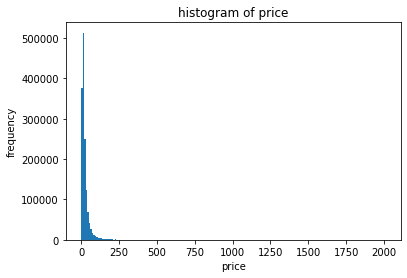

In [0]:
plt.hist(data['price'], bins=200)
plt.xlabel('price')
plt.ylabel('frequency')
plt.title('histogram of price')
plt.show()

##### The above histogram is not very interpretable, let's try using log of price instead of price in the above plot.

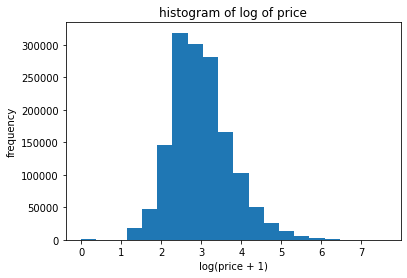

In [0]:
plt.hist(data['price_log'], bins=20)
plt.xlabel('log(price + 1)')
plt.ylabel('frequency')
plt.title('histogram of log of price')
plt.show()

## train_id - (numerical feature)

In [0]:
data['train_id'].describe()

count    1.482535e+06
mean     7.412670e+05
std      4.279711e+05
min      0.000000e+00
25%      3.706335e+05
50%      7.412670e+05
75%      1.111900e+06
max      1.482534e+06
Name: train_id, dtype: float64

In [0]:
# I think this 'train_id' feature is useless and may lead to data leakage.

## item_condition_id (categorical feature)

In [0]:
data['item_condition_id'].value_counts()

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

In [0]:
print('Number of products with item_condition_id not defined:')
data['item_condition_id'].isna().sum()

Number of products with item_condition_id not defined:


0

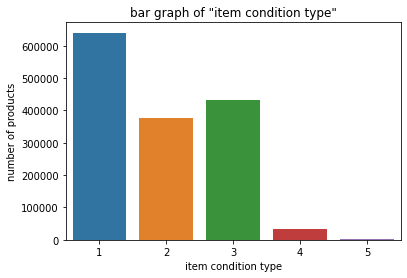

In [0]:
sns.barplot(x=data['item_condition_id'].value_counts().keys(), y=data['item_condition_id'].value_counts())
plt.xlabel('item condition type')
plt.ylabel('number of products')
plt.title('bar graph of "item condition type"')
plt.show()

##### We can see that a majority of items have a condition id of 1, and only a few items have a condition id of 5.

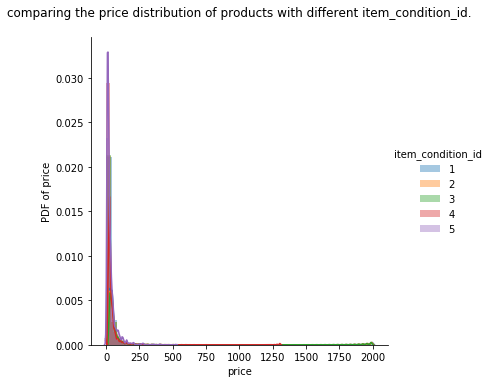

In [0]:
sns.FacetGrid(data, hue="item_condition_id", height=5).map(sns.distplot, 'price').add_legend();
plt.title('comparing the price distribution of products with different item_condition_id.\n')
plt.ylabel('PDF of price')
plt.show()

##### The above histogram is not very interpretable, let's try using log of price instead of price in the above plot.

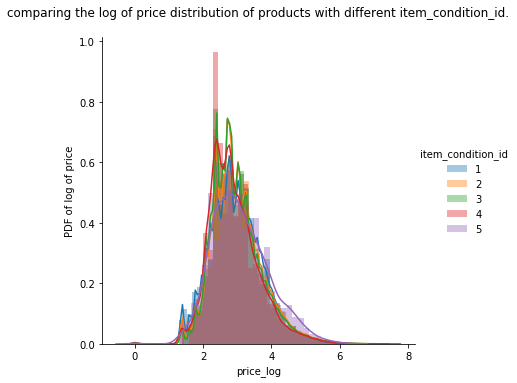

In [0]:
sns.FacetGrid(data, hue="item_condition_id", height=5).map(sns.distplot, 'price_log').add_legend();
plt.title('comparing the log of price distribution of products with different item_condition_id.\n')
plt.ylabel('PDF of log of price')
plt.show()

##### We can see that the price distribution of items having different item_condition_id are very similar.

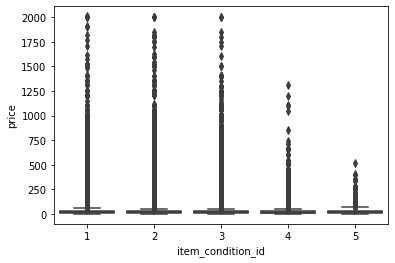

In [0]:
sns.boxplot(x='item_condition_id', y='price', data=data)
plt.show()

##### The above histogram is not very interpretable still we can conclude that max price of items with condition id 1 is 3 times of items with condition id 5, let's try using log of price instead of price in the above plot.

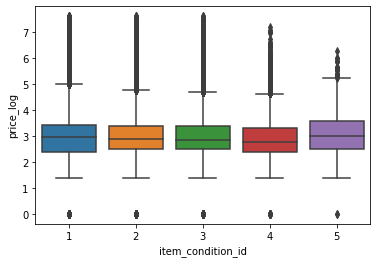

In [0]:
sns.boxplot(x='item_condition_id', y='price_log', data=data)
plt.show()

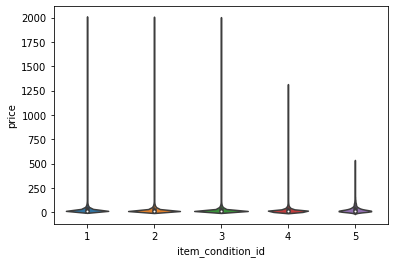

In [0]:
sns.violinplot(x='item_condition_id', y='price', data=data)
plt.show()

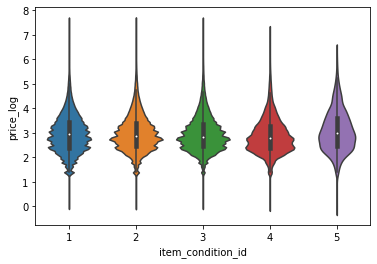

In [0]:
sns.violinplot(x='item_condition_id', y='price_log', data=data)
plt.show()

##### The boxplot and violin plots also tell us that price distribution of items with different item_condition_id is not so different different, they all are little to more right skewed.

## Category_name

##### let's check the unique number of values in category_name.

In [0]:
data['category_name'].unique().shape

(1288,)

In [0]:
data['category_name'].describe()

count                                            1476208
unique                                              1287
top       Women/Athletic Apparel/Pants, Tights, Leggings
freq                                               60177
Name: category_name, dtype: object

In [0]:
print('Number of products with category not defined:')
data['category_name'].isna().sum()

Number of products with category not defined:


0

#### I've divided the category name feature into 3 new features -> sub_category_1, sub_category_2, sub_category_3

#### sub_category_1

In [0]:
data['sub_category_1'].describe()

count     1482535
unique         11
top         Women
freq       664385
Name: sub_category_1, dtype: object

##### We can see that the sub_category_1 contains 11 unique values, let's analyze them further.

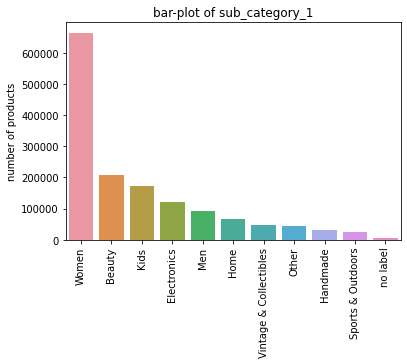

In [0]:
sns.barplot(x=data['sub_category_1'].value_counts().keys(), y=data['sub_category_1'].value_counts())
plt.ylabel('number of products')
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title('bar-plot of sub_category_1')
plt.show()

##### We can see that most of the items have sub_category_1 as 'women' and the least items have 'Sports & Outdoors'.
##### \# note that items with no sub_category_1 defined are denoted with 'no label'.

#### Let's check the price distribution of sub_category_1 and price

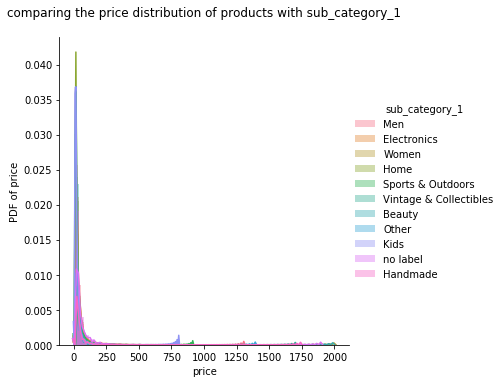

In [0]:
sns.FacetGrid(data, hue="sub_category_1", height=5).map(sns.distplot, 'price').add_legend();
plt.title('comparing the price distribution of products with sub_category_1\n')
plt.ylabel('PDF of price')
plt.show()

#### Let's check the distribution of sub_category_1 and log of price

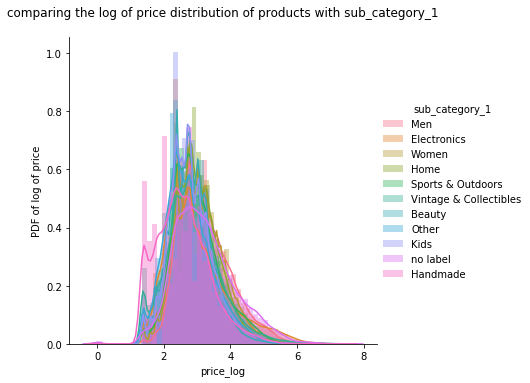

In [0]:
sns.FacetGrid(data, hue="sub_category_1", height=5).map(sns.distplot, 'price_log').add_legend();
plt.title('comparing the log of price distribution of products with sub_category_1\n')
plt.ylabel('PDF of log of price')
plt.show()

##### We can see that most of the distributions are right skewed with a little difference.

In [0]:
sns.FacetGrid(data, hue="item_condition_id", height=5).map(sns.distplot, 'price').add_legend();
plt.title('comparing the price distribution of products with different item_condition_id.\n')
plt.ylabel('PDF of price')
plt.show()

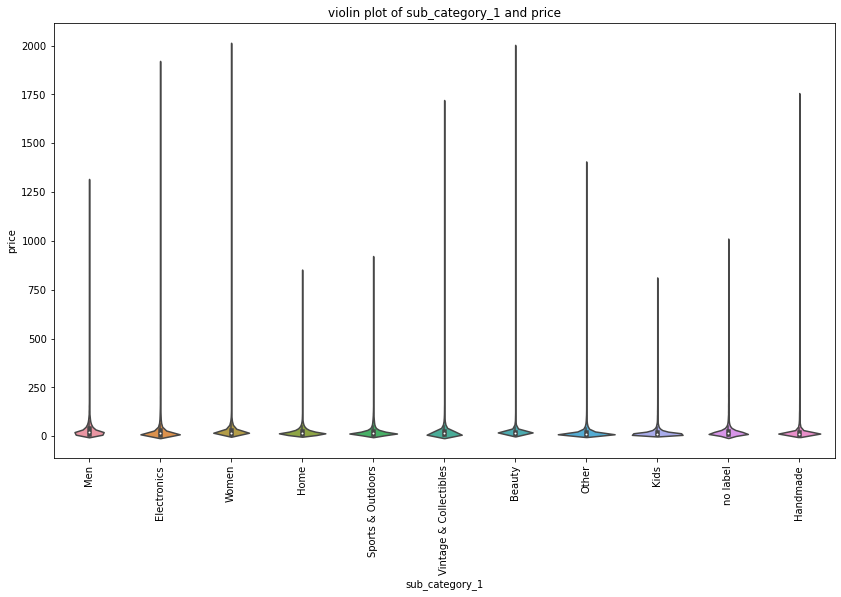

In [0]:
plt.figure(figsize=(14,8))
sns.violinplot(x='sub_category_1', y='price', data=data)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title('violin plot of sub_category_1 and price')
plt.show()

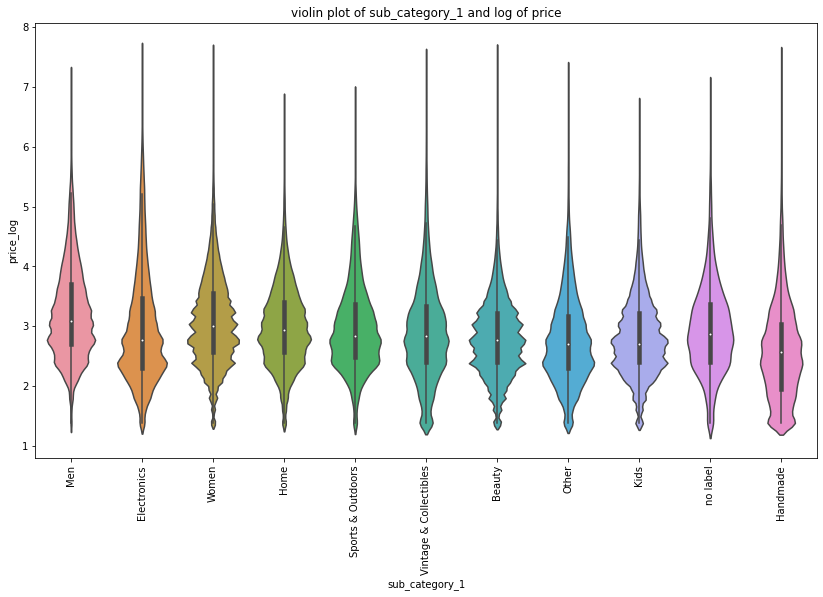

In [0]:
plt.figure(figsize=(14,8))
sns.violinplot(x='sub_category_1', y='price_log', data=data)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title('violin plot of sub_category_1 and log of price')
plt.show()

##### Looking at the violin plot, we can say that the distribution of items with 'men' as sub_category_1 tend to be on the pricier end whereas items with 'homemade' as sub_category_1 tend to be on the economical end.

#### sub_category_2

In [0]:
data['sub_category_2'].value_counts()

Athletic Apparel        134383
Makeup                  124624
Tops & Blouses          106960
Shoes                   100452
Jewelry                  61763
                         ...  
Candles                     64
Ceramics and Pottery        57
Dolls and Miniatures        49
Books and Zines             46
Quilts                      31
Name: sub_category_2, Length: 114, dtype: int64

##### sub_category_2 has 114 distinct values, let's analyze the top 20 categories of sub_category_2

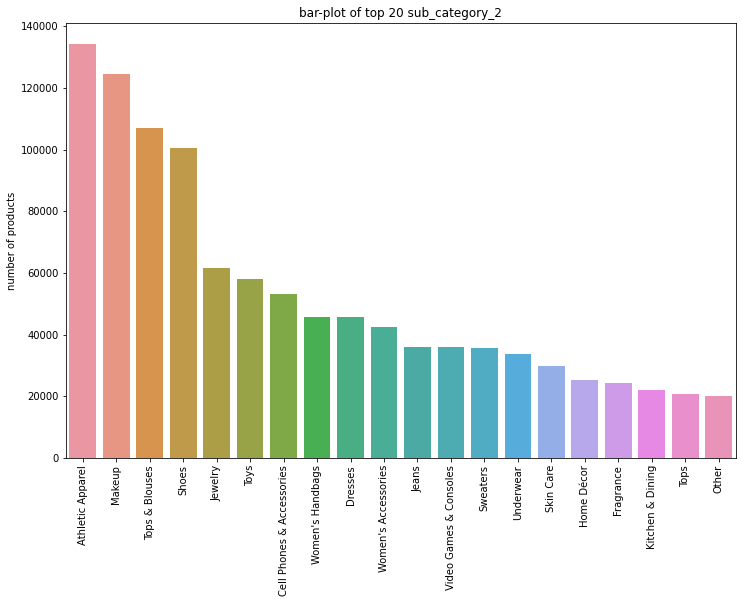

In [0]:
plt.figure(figsize=(12,8))
sns.barplot(x=data['sub_category_2'].value_counts().keys()[:20], y=data['sub_category_2'].value_counts()[:20])
plt.ylabel('number of products')
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title('bar-plot of top 20 sub_category_2')
plt.show()

#### subcategory_3

In [0]:
data['sub_category_3'].value_counts()

Pants, Tights, Leggings    60177
Other                      50224
Face                       50171
T-Shirts                   46380
Shoes                      32168
                           ...  
Map                            1
Pet Food                       1
Mirror                         1
New Years                      1
Artist Bears                   1
Name: sub_category_3, Length: 865, dtype: int64

##### sub_category_3 has 865 distinct values, let's analyze the top 20 categories of sub_category_3

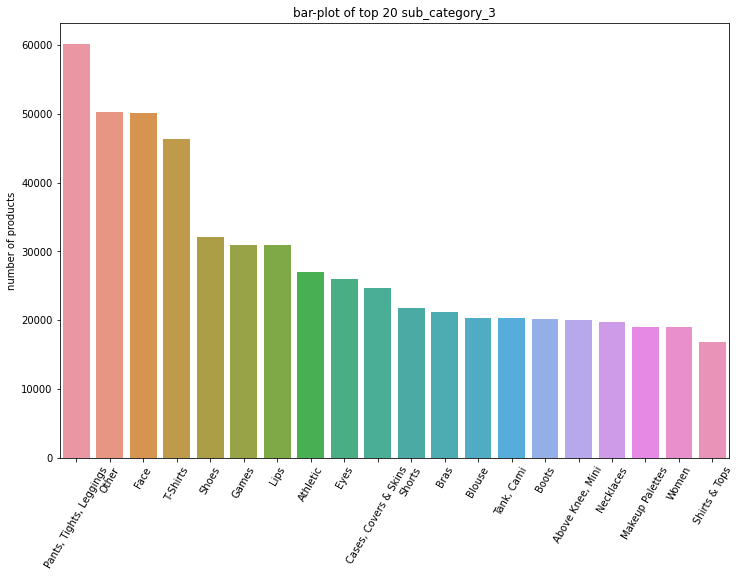

In [0]:
plt.figure(figsize=(12,8))
sns.barplot(x=data['sub_category_3'].value_counts().keys()[:20], y=data['sub_category_3'].value_counts()[:20])
plt.ylabel('number of products')
locs, labels = plt.xticks()
plt.setp(labels, rotation=60)
plt.title('bar-plot of top 20 sub_category_3')
plt.show()

## brand_name

In [0]:
data['brand_name'].value_counts()

PINK                                54088
Nike                                54043
Victoria's Secret                   48036
LuLaRoe                             31024
Apple                               17322
                                    ...  
Reunion                                 1
Madam C.J. Walker Beauty Culture        1
Riff Stars                              1
Chequer                                 1
Anne Geddes                             1
Name: brand_name, Length: 4809, dtype: int64

##### feature brand_name has 4809 distinct values, let's analyze the top 20 brand_names

In [0]:
print('Number of NaN values in brand_name:')
data['brand_name'].isna().sum()

Number of NaN values in brand_name:


0

In [0]:
data['brand_name'] = data['brand_name'].fillna('unknown') # replacing NaN values with 'none'

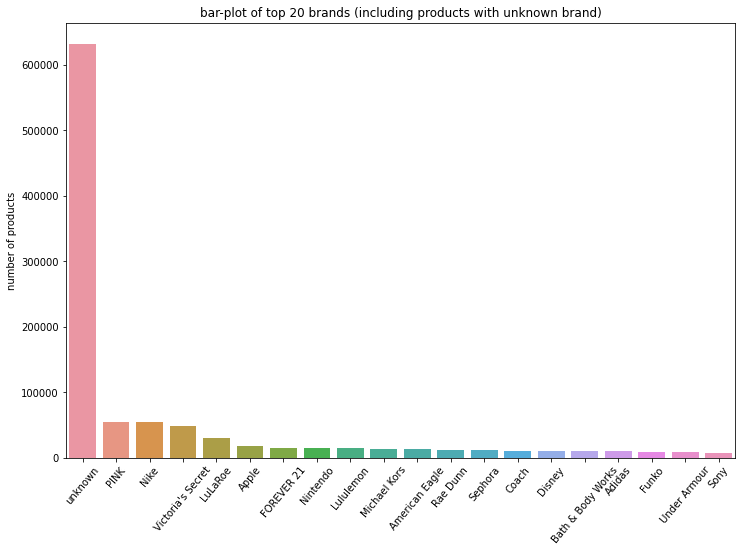

In [0]:
plt.figure(figsize=(12,8))
sns.barplot(x=data['brand_name'].value_counts().keys()[:20], y=data['brand_name'].value_counts()[:20])
plt.ylabel('number of products')
locs, labels = plt.xticks()
plt.setp(labels, rotation=50)
plt.title('bar-plot of top 20 brands (including products with unknown brand)')
plt.show()

##### Plotting top brands with their mean product price

In [0]:
df = data.groupby('brand_name')['price'].mean().reset_index().sort_values(by='price', ascending=False)
df.head(5)

,brand_name,price
1221,Demdaco,429.000000
3463,Proenza Schouler,413.250000
346,Auto Meter,344.000000
3185,Oris,300.000000
2654,MCM Worldwide,289.173913


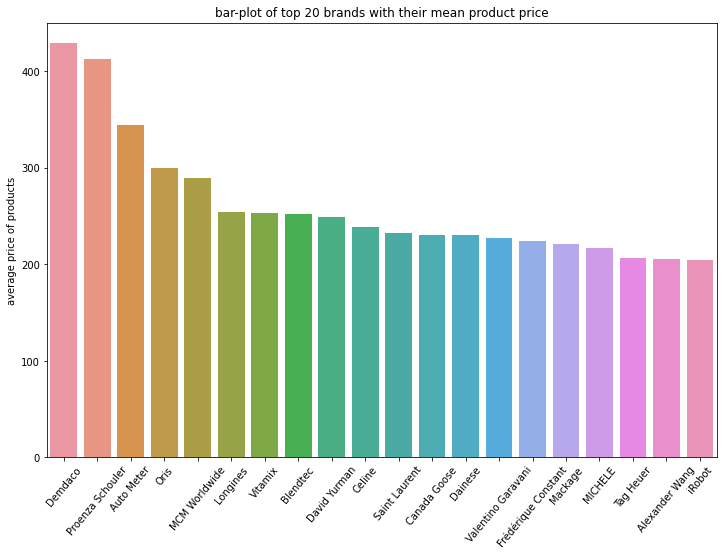

In [0]:
plt.figure(figsize=(12,8))
sns.barplot(x=df['brand_name'].values[:20], y=df['price'].values[:20])
plt.ylabel('average price of products')
locs, labels = plt.xticks()
plt.setp(labels, rotation=50)
plt.title('bar-plot of top 20 brands with their mean product price')
plt.show()


##### Plotting top brands with maximum product price

In [0]:
df = data.groupby('brand_name')['price'].max().reset_index().sort_values(by='price', ascending=False)
df.head(5)

,brand_name,price
899,Chanel,2009.0
1197,David Yurman,2004.0
4805,unknown,2000.0
2760,Mary Kay,2000.0
267,Apple,1909.0


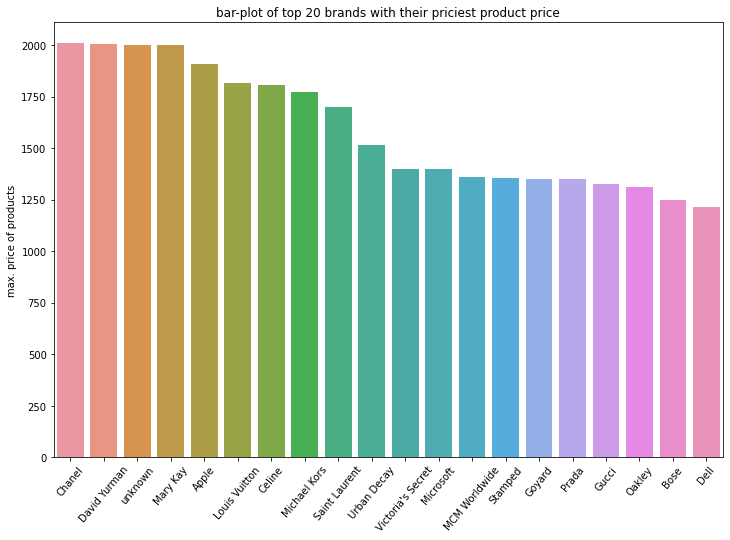

In [0]:
plt.figure(figsize=(12,8))
sns.barplot(x=df['brand_name'].values[:20], y=df['price'].values[:20])
plt.ylabel('max. price of products')
locs, labels = plt.xticks()
plt.setp(labels, rotation=50)
plt.title('bar-plot of top 20 brands with their priciest product price')
plt.show()

### Shipping (categorical)

In [0]:
data['shipping'].value_counts()

0    819435
1    663100
Name: shipping, dtype: int64

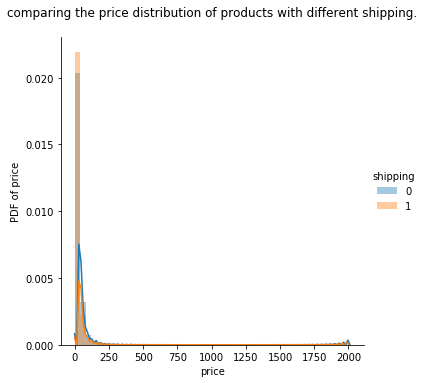

In [0]:
sns.FacetGrid(data, hue="shipping", height=5).map(sns.distplot, 'price').add_legend();
plt.title('comparing the price distribution of products with different shipping.\n')
plt.ylabel('PDF of price')
plt.show()

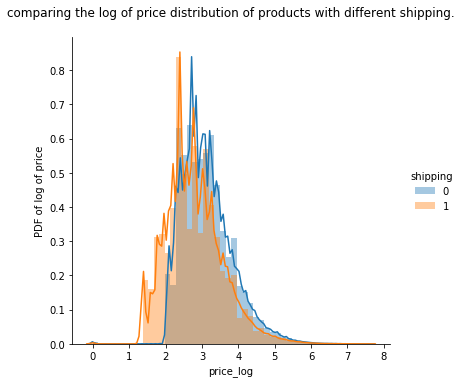

In [0]:
sns.FacetGrid(data, hue="shipping", height=5).map(sns.distplot, 'price_log').add_legend();
plt.title('comparing the log of price distribution of products with different shipping.\n')
plt.ylabel('PDF of log of price')
plt.show()

##### We can see that the log of price distribution of items with different shipping have a slight variance.

## item_description (text)

In [0]:
# Nothing much to see here, I'll use this data straight for processing.

In [0]:
data['item_description']

0                                         No description yet
1          This keyboard is in great condition and works ...
2          Adorable top with a hint of lace and a key hol...
3          New with tags. Leather horses. Retail for [rm]...
4                  Complete with certificate of authenticity
                                 ...                        
1482530    Lace, says size small but fits medium perfectl...
1482531     Little mermaid handmade dress never worn size 2t
1482532            Used once or twice, still in great shape.
1482533    There is 2 of each one that you see! So 2 red ...
1482534    New with tag, red with sparkle. Firm price, no...
Name: item_description, Length: 1482535, dtype: object

In [0]:
print('Number of products with item_description not defined:')
data['item_description'].isna().sum()

Number of products with item_description not defined:


0

### Character length of item description (numerical)

In [0]:
data['item_description_char_length'].describe()

count    1.482535e+06
mean     1.457114e+02
std      1.744464e+02
min      0.000000e+00
25%      4.000000e+01
50%      8.600000e+01
75%      1.740000e+02
max      1.046000e+03
Name: item_description_char_length, dtype: float64

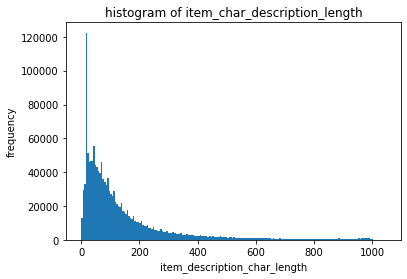

In [0]:
plt.hist(data['item_description_char_length'], bins=200)
plt.xlabel('item_description_char_length')
plt.ylabel('frequency')
plt.title('histogram of item_char_description_length')
plt.show()

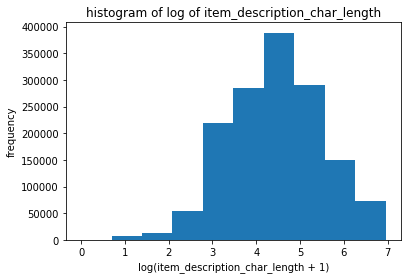

In [0]:
plt.hist(data['log_item_description_char_length'])#.apply(lambda x:np.log(x+1)))
plt.xlabel('log(item_description_char_length + 1)')
plt.ylabel('frequency')
plt.title('histogram of log of item_description_char_length')
plt.show()

In [0]:
df = data.groupby('item_description_char_length')['price'].mean().reset_index()

<Figure size 864x576 with 0 Axes>

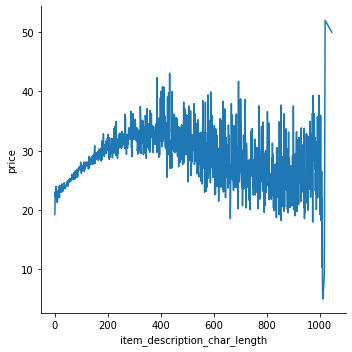

In [0]:
plt.figure(figsize=(12,8))
sns.relplot(x="item_description_char_length", y="price", kind="line", data=df)
plt.show()

In [0]:
df = data.groupby('item_description_char_length')['price_log'].mean().reset_index()

<Figure size 864x576 with 0 Axes>

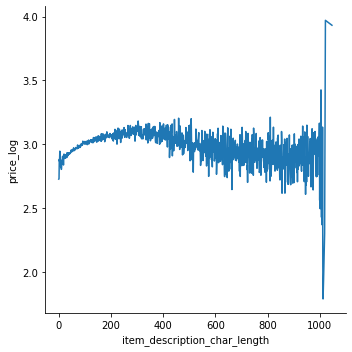

In [0]:
plt.figure(figsize=(12,8))
sns.relplot(x="item_description_char_length", y="price_log", kind="line", data=df)
plt.show()

### word length of item description

In [0]:
data['item_description_word_length'].describe()

count    1.482535e+06
mean     2.568525e+01
std      3.038409e+01
min      0.000000e+00
25%      7.000000e+00
50%      1.500000e+01
75%      3.100000e+01
max      2.450000e+02
Name: item_description_word_length, dtype: float64

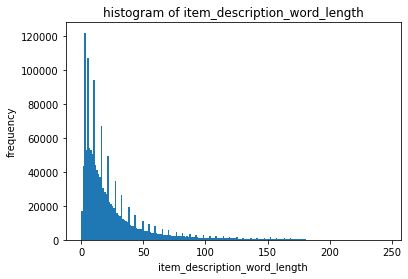

In [0]:
plt.hist(data['item_description_word_length'], bins=200)
plt.xlabel('item_description_word_length')
plt.ylabel('frequency')
plt.title('histogram of item_description_word_length')
plt.show()

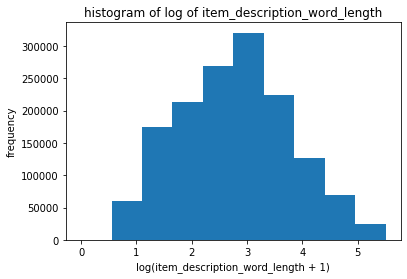

In [0]:
plt.hist(data['log_item_description_word_length'])
plt.xlabel('log(item_description_word_length + 1)')
plt.ylabel('frequency')
plt.title('histogram of log of item_description_word_length')
plt.show()

In [0]:
df = data.groupby('item_description_word_length')['price'].mean().reset_index()

<Figure size 864x576 with 0 Axes>

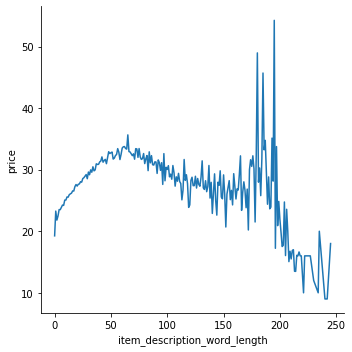

In [0]:
plt.figure(figsize=(12,8))
sns.relplot(x="item_description_word_length", y="price", kind="line", data=df)
plt.show()

##### The price of items first increase as the word length increase till 50 and then decreases. Again there is a spike around 190.

In [0]:
df = data.groupby('item_description_word_length')['price_log'].mean().reset_index()

<Figure size 864x576 with 0 Axes>

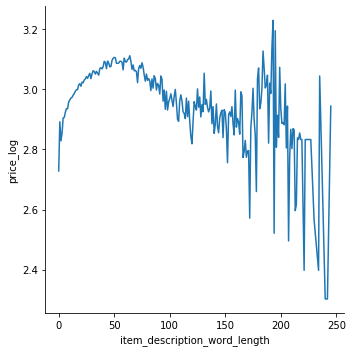

In [0]:
plt.figure(figsize=(12,8))
sns.relplot(x="item_description_word_length", y="price_log", kind="line", data=df)
plt.show()

In [0]:
data.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'price_log', 'sub_category_1',
       'sub_category_2', 'sub_category_3', 'name_length',
       'item_description_length', 'log_item_description_length'],
      dtype='object')

### Name (text)

In [0]:
data['name_length'].describe()

count    1.482535e+06
mean     2.578640e+01
std      9.164533e+00
min      1.000000e+00
25%      1.900000e+01
50%      2.600000e+01
75%      3.400000e+01
max      4.300000e+01
Name: name_length, dtype: float64

In [0]:
print('Number of products with name not defined:')
data['name'].isna().sum()

Number of products with name not defined:


0

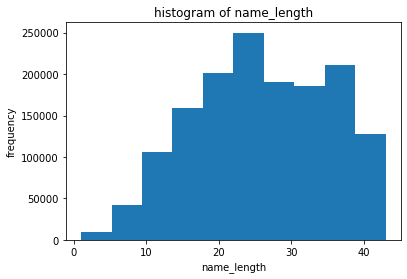

In [0]:
plt.hist(data['name_length'])
plt.xlabel('name_length')
plt.ylabel('frequency')
plt.title('histogram of name_length')
plt.show()

<Figure size 864x576 with 0 Axes>

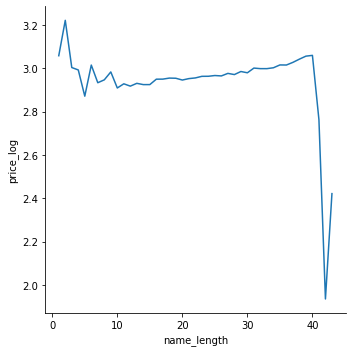

In [0]:
df = data.groupby('name_length')['price_log'].mean().reset_index()
plt.figure(figsize=(12,8))
sns.relplot(x="name_length", y="price_log", kind="line", data=df)
plt.show()

##### The log price of items is constant with item name_length, and then decreases after name_length crosses 40.

## text preprocessing

##### Merging the text features -> name, brand, item_description & sub_category_3 together.

In [0]:
data['item_description'].isna().sum()

0

In [0]:
all_text_features = []
for i in zip(data['name'],data['brand_name'],data['item_description'],data['sub_category_3']):
  all_text_features.append(' '.join(i))
all_text_features[:3]

['MLB Cincinnati Reds T Shirt Size XL unknown No description yet T-shirts',
 'Razer BlackWidow Chroma Keyboard Razer This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC. Components & Parts',
 'AVA-VIV Blouse Target Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white! Blouse']

In [0]:
data['all_text_features'] = all_text_features

In [0]:
import re
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", '•', '❤', '✨', '$', '❌', '♡', '☆', '✔', '⭐',
            '✅', '⚡', '‼', '—', '▪', '❗', '■', '●', '➡',
            '⛔', '♦', '〰', '×', '⚠', '°', '♥', '★', '®', '·', '☺', '–', '➖',
            '✴', '❣', '⚫', '✳', '➕', '™', 'ᴇ', '》', '✖', '▫', '¤',
            '⬆', '⃣', 'ᴀ', '❇', 'ᴏ', '《', '☞', '❄', '»', 'ô', '❎', 'ɴ', '⭕', 'ᴛ',
            '◇', 'ɪ', '½', 'ʀ', '❥', '⚜', '⋆', '⏺', '❕', 'ꕥ', '：', '◆', '✽',
            '…', '☑', '︎', '═', '▶', '⬇', 'ʟ', '！', '✈', '�', '☀', 'ғ']

In [0]:
from tqdm import tqdm_notebook
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentence in tqdm_notebook(text_data):
        sent = decontracted(sentence)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

## Preprocessing Item description + name (text)

In [0]:
preprocessed_all_text_features = preprocess_text(data['all_text_features'].fillna('').values) # list of cleaned data in 'item_description'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


### Picking up the necessary features.

In [0]:
y = data['price'].values
X = data[['item_condition_id', 'shipping', 'name_length', 'sub_category_1', 'sub_category_2', 'log_item_description_char_length']]
X['preprocessed_text'] = preprocessed_all_text_features
X.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,item_condition_id,shipping,name_length,sub_category_1,sub_category_2,log_item_description_char_length,preprocessed_text
0,3,1,35,Men,Tops,2.944439,mlb cincinnati reds shirt size xl unknown no d...
1,3,0,32,Electronics,Computers & Tablets,5.241747,razer blackwidow chroma keyboard razer keyboar...
2,1,1,14,Women,Tops & Blouses,4.828314,ava viv blouse target adorable top hint lace k...
3,1,1,21,Home,Home Décor,5.159055,leather horse statues unknown new tags leather...
4,1,0,20,Women,Jewelry,3.737670,24k gold plated rose unknown complete certific...


### Adding new features

##### These are the features that I think contribute very much to the correct price prediction because they contain vital information about the data like if the product is a gold chain, we want to obtain information like is it 18 karat, 22 karat or 24 karat. Similarly if the product is a pack of lipsticks, we want to obtain information like how many lipsticks are there in that pack, since some packs have 10 lipsticks and other have 20. Therefore the price depends on these feature heavily. 

In [0]:
patterns = [
        "([0-9.]+)[ ]?\$",
        "\$[ ]?([0-9.]+)",
        "paid ([0-9.]+)",
        "bought for (\d+)"
        "(10|14|18|24) gold",
        "of (\d+) ",
        " (\d+) ship",
        "is for all (\d+)",
        "is for (\d+)",
        "firm for (\d+)",
        "bundl \w+ (\d+) ",
        "(\d+) in 1",
        "^(\d+)",
        "\d+ for (\d+)",
        " x(\d+)",
        "\b(\d+)x\b",
        "(\d+)% left",
        "(\d+)[ ]?lipstick"]

In [0]:
XX =  pd.DataFrame() # initializing a new dataframe that
def new_features(X, patterns):
  i=0
  for pattern_name in tqdm_notebook(patterns): # iterating over the different patterns
    features = []
    new_col = f'regex_pattern_{i}' # column denoting the new feature corresponding to that feature
    for text in tqdm_notebook(X['preprocessed_text'].values): # iterating over the dataframe rows
      results = re.findall(pattern_name, text) # finding the pattern using regex
      if len(results): 
        features.append(np.mean([int(i) if int(i)<2000 else 0 for i in results])) # storing the result if it is < 2000 because some numerical feature correspond to the year being sold.
      else: features.append(0.)
    XX[new_col] = features
    i+=1
  return XX

In [0]:
new_feat = new_features(X, patterns)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [0]:
new_feat.head(5)

,regex_pattern_0,regex_pattern_1,regex_pattern_2,regex_pattern_3,regex_pattern_4,regex_pattern_5,regex_pattern_6,regex_pattern_7,regex_pattern_8,regex_pattern_9,regex_pattern_10,regex_pattern_11,regex_pattern_12,regex_pattern_13,regex_pattern_14,regex_pattern_15,regex_pattern_16
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# concatenating the old and new features
X = pd.concat([X, new_feat], axis=1, sort=False)

In [0]:
X.head(5)

,item_condition_id,shipping,name_length,sub_category_1,sub_category_2,log_item_description_char_length,preprocessed_text,regex_pattern_0,regex_pattern_1,regex_pattern_2,regex_pattern_3,regex_pattern_4,regex_pattern_5,regex_pattern_6,regex_pattern_7,regex_pattern_8,regex_pattern_9,regex_pattern_10,regex_pattern_11,regex_pattern_12,regex_pattern_13,regex_pattern_14,regex_pattern_15,regex_pattern_16
0,3,1,35,Men,Tops,2.944439,mlb cincinnati reds shirt size xl unknown no d...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,0,32,Electronics,Computers & Tablets,5.241747,razer blackwidow chroma keyboard razer keyboar...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,14,Women,Tops & Blouses,4.828314,ava viv blouse target adorable top hint lace k...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1,21,Home,Home Décor,5.159055,leather horse statues unknown new tags leather...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,20,Women,Jewelry,3.737670,24k gold plated rose unknown complete certific...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0


### Train test split

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.05, random_state=42)

### TF-IDF encoding text data (preprocessed_text)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
print('dimensions of training data: \n', X_train.shape, y_train.shape)
print('dimensions of cross-validation data: \n', X_cv.shape, y_cv.shape)
# print('dimensions of test data: \n', X_test.shape, y_test.shape)

print("="*100)

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=200000)
tfidf_vectorizer.fit(X_train['preprocessed_text'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_preprocessed_text = tfidf_vectorizer.transform(X_train['preprocessed_text'].values)
X_cv_preprocessed_text = tfidf_vectorizer.transform(X_cv['preprocessed_text'].values)
# X_test_preprocessed_text = tfidf_vectorizer.transform(X_test['preprocessed_text'].values)

print("After vectorizations")
print('dimensions of training data: \n', X_train_preprocessed_text.shape, y_train.shape)
print('dimensions of cross-validation data: \n', X_cv_preprocessed_text.shape, y_cv.shape)
# print('dimensions of test data: \n', X_test_preprocessed_text.shape, y_test.shape)
print("="*100)

print("NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME")

dimensions of training data: 
 (1407577, 24) (1407577,)
dimensions of cross-validation data: 
 (74084, 24) (74084,)
After vectorizations
dimensions of training data: 
 (1407577, 200000) (1407577,)
dimensions of cross-validation data: 
 (74084, 200000) (74084,)
NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME


### Label Encoding item_condition_id

In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()
label_encoder.fit(X_train['item_condition_id'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_item_condition_id_le = label_encoder.transform(X_train['item_condition_id'].values).reshape(-1,1)
X_cv_item_condition_id_le = label_encoder.transform(X_cv['item_condition_id'].values).reshape(-1,1)

In [0]:
X_train_item_condition_id_le.shape

(1407577, 1)

### One-Hot-Encoding sub_category_1

In [0]:
OH_encoder = OneHotEncoder()
OH_encoder.fit(X_train['sub_category_1'].values.reshape(-1, 1)) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_sub_category_1_ohe = OH_encoder.transform(X_train['sub_category_1'].values.reshape(-1, 1))
X_cv_sub_category_1_ohe = OH_encoder.transform(X_cv['sub_category_1'].values.reshape(-1, 1))
# X_test_sub_category_1_ohe = OH_encoder.transform(X_test['sub_category_1'].values.reshape(-1, 1))

In [0]:
X_train_sub_category_1_ohe.toarray().shape

(1407577, 11)

### One-Hot-Encoding sub_category_2

In [0]:
OH_encoder = OneHotEncoder()
OH_encoder.fit(X_train['sub_category_2'].values.reshape(-1, 1)) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_sub_category_2_ohe = OH_encoder.transform(X_train['sub_category_2'].values.reshape(-1, 1))
X_cv_sub_category_2_ohe = OH_encoder.transform(X_cv['sub_category_2'].values.reshape(-1, 1))
# X_test_sub_category_2_ohe = OH_encoder.transform(X_test['sub_category_2'].values.reshape(-1, 1))

In [0]:
X_train_sub_category_2_ohe.toarray().shape

(1407577, 114)

In [0]:
OH_encoder = OneHotEncoder()
OH_encoder.fit(X_train['shipping'].values.reshape(-1, 1)) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_shipping_ohe = OH_encoder.transform(X_train['shipping'].values.reshape(-1, 1))
X_cv_shipping_ohe = OH_encoder.transform(X_cv['shipping'].values.reshape(-1, 1))
# X_test_shipping_ohe = OH_encoder.transform(X_test['shipping'].values.reshape(-1, 1))

In [0]:
X_train_shipping_ohe.shape

(1407577, 2)

### Standardizing numerical data

In [0]:
X.columns

Index(['item_condition_id', 'shipping', 'name_length', 'sub_category_1',
       'sub_category_2', 'log_item_description_char_length',
       'preprocessed_text', 'regex_pattern_0', 'regex_pattern_1',
       'regex_pattern_2', 'regex_pattern_3', 'regex_pattern_4',
       'regex_pattern_5', 'regex_pattern_6', 'regex_pattern_7',
       'regex_pattern_8', 'regex_pattern_9', 'regex_pattern_10',
       'regex_pattern_11', 'regex_pattern_12', 'regex_pattern_13',
       'regex_pattern_14', 'regex_pattern_15', 'regex_pattern_16'],
      dtype='object')

In [0]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
features = ['name_length', 'log_item_description_char_length', 'regex_pattern_0', 'regex_pattern_1',
            'regex_pattern_2', 'regex_pattern_3', 'regex_pattern_4',
            'regex_pattern_5', 'regex_pattern_6', 'regex_pattern_7',
            'regex_pattern_8', 'regex_pattern_9', 'regex_pattern_10',
            'regex_pattern_11', 'regex_pattern_12', 'regex_pattern_13',
            'regex_pattern_14', 'regex_pattern_15', 'regex_pattern_16']
std_scaler.fit(X_train[features].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_numerical_features_std = std_scaler.transform(X_train[features].values)
X_cv_numerical_features_std = std_scaler.transform(X_cv[features].values)

In [0]:
X_train_numerical_features_std.shape

(1407577, 19)

### standardizing 'price'

In [0]:
from sklearn.preprocessing import StandardScaler
y_scaler = StandardScaler()

y_scaler.fit(np.log1p(y_train.reshape(-1, 1))) # fit has to happen only on train data

y_train_std = y_scaler.transform(np.log1p(y_train.reshape(-1, 1)))#.reshape(1,-1)[0]
y_cv_std = y_scaler.transform(np.log1p(y_cv.reshape(-1, 1)))#.reshape(1,-1)[0]

### stacking the prepared data

In [0]:
from scipy.sparse import hstack
X_tr = hstack((X_train_preprocessed_text, X_train_item_condition_id_le, X_train_sub_category_1_ohe, X_train_sub_category_2_ohe,
               X_train_numerical_features_std, X_train_shipping_ohe)).tocsr()

X_cv = hstack((X_cv_preprocessed_text, X_cv_item_condition_id_le, X_cv_sub_category_1_ohe, X_cv_sub_category_2_ohe,
               X_cv_numerical_features_std, X_cv_shipping_ohe)).tocsr()

print("Final Data matrix")
print('dimensions of training data: \n', X_tr.shape, y_train.shape)
print('dimensions of cross-validation data: \n', X_cv.shape, y_cv.shape)
print("="*100)

Final Data matrix
dimensions of training data: 
 (1407577, 200147) (1407577,)
dimensions of cross-validation data: 
 (74084, 200147) (74084,)


In [0]:
from scipy import sparse
sparse.save_npz("drive/My Drive/marcari_kaggle_data/sparse_data/new_one/X_tr.npz", X_tr)
sparse.save_npz("drive/My Drive/marcari_kaggle_data/sparse_data/new_one/X_cv.npz", X_cv)

np.save("drive/My Drive/marcari_kaggle_data/sparse_data/new_one/y_train_new", y_train)
np.save("drive/My Drive/marcari_kaggle_data/sparse_data/new_one/y_cv_new", y_cv)

In [0]:
from sklearn.preprocessing import StandardScaler
y_scaler = StandardScaler()

X_tr = sparse.load_npz("drive/My Drive/marcari_kaggle_data/sparse_data/new_one/X_tr.npz")
X_cv = sparse.load_npz("drive/My Drive/marcari_kaggle_data/sparse_data/new_one/X_cv.npz")

y_train = np.load("drive/My Drive/marcari_kaggle_data/sparse_data/new_one/y_train_new.npy")
y_cv = np.load("drive/My Drive/marcari_kaggle_data/sparse_data/new_one/y_cv_new.npy")
y_train_std = y_scaler.fit_transform(np.log1p(y_train.reshape(-1, 1)))
y_cv_std = y_scaler.transform(np.log1p(y_cv.reshape(-1, 1)))

In [0]:
# Let's try fitting the data quickly using Ridge regressor.
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as msle
from sklearn.linear_model import Ridge
import numpy as np

ridge_regressor = Ridge(alpha=0.01)
print('Fitting......')
ridge_regressor.fit(X_tr, y_train_std)
print('Fitting completed!')

Fitting......
Fitting completed!


In [0]:
y_pred = ridge_regressor.predict(X_tr)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
print ('Train log-loss:', np.sqrt(msle(y_train, y_pred)))
y_pred = ridge_regressor.predict(X_cv)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
print ('CV log-loss:', np.sqrt(msle(y_cv, y_pred)))

Train log-loss: 0.647113467698032
CV log-loss: 0.69524566215668


#### Let's try to reduce the data size by selecting only top features.
##### I'll be using XGBRegressor for that.

In [0]:
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
xgb_reg = XGBRegressor(n_jobs=-1)
selection = SelectFromModel(xgb_reg, threshold=1e-4)
selection.fit(X_tr, y_train_std)

[08:23:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SelectFromModel(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       colsample_bylevel=1, colsample_bynode=1,
                                       colsample_bytree=1, gamma=0,
                                       importance_type='gain',
                                       learning_rate=0.1, max_delta_step=0,
                                       max_depth=3, min_child_weight=1,
                                       missing=None, n_estimators=100,
                                       n_jobs=-1, nthread=None,
                                       objective='reg:linear', random_state=0,
                                       reg_alpha=0, reg_lambda=1,
                                       scale_pos_weight=1, seed=None,
                                       silent=None, subsample=1, verbosity=1),
            

In [0]:
X_train_top = selection.transform(X_tr)
X_cv_top = selection.transform(X_cv)

In [0]:
# Let's fit this new data using Ridge regressor
ridge_regressor = Ridge(alpha=0.01)
print('Fitting......')
ridge_regressor.fit(X_train_top, y_train_std)
print('Fitting completed!')

Fitting......
Fitting completed!


In [0]:
y_pred = ridge_regressor.predict(X_tr)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
print ('Train log-loss:', 0.948246294493267)
y_pred = ridge_regressor.predict(X_cv)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
print ('CV log-loss:', 0.968342526560032)

Train log-loss: 0.948246294493267
CV log-loss: 0.968342526560032


##### We can see that the preformance is not good, I figured out that I was using too many features. But after trying many work-arounds like clipping tfidf values, top featore selector, truncated svd etc. I found the below combination to work the best.
##### I refered from kaggle no. 1 solution by Paweł and Konstantin, for the approach which is very simple and effective.

## Let's try with less number of features.

In [0]:
import pandas as pd
import numpy as np

In [0]:
# train data
df = pd.read_table('drive/My Drive/marcari_kaggle_data/train.tsv')
df = df[df['price'] > 0].reset_index(drop=True) # dropping the rows with price=0
y = df['price'] # storing price in y
df['name'] = df['name'].fillna('') + ' ' + df['brand_name'].fillna('')
df['text'] = (df['item_description'].fillna('') + ' ' + df['name'] + ' ' + df['category_name'].fillna('')) # Creating text features by concatenation.
df =  df[['name', 'text', 'shipping', 'item_condition_id']]

# test data
# !unzip 'drive/My Drive/marcari_kaggle_data/test_stg2.tsv.zip'
df_test = pd.read_table('test_stg2.tsv')
df_test['name'] = df_test['name'].fillna('') + ' ' + df_test['brand_name'].fillna('')
df_test['text'] = (df_test['item_description'].fillna('') + ' ' + df_test['name'] + ' ' + df_test['category_name'].fillna('')) # Creating text features by concatenation.
np.save("drive/My Drive/marcari_kaggle_data/sparse_data/test_id.npy", df_test['test_id'].values)
X_test = df_test[['name', 'text', 'shipping', 'item_condition_id']]

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
y_scaler = StandardScaler()
X_train, X_cv, y_train, y_cv = train_test_split(df, y, test_size=0.05, random_state=42)
y_train_std = y_scaler.fit_transform(np.log1p(y_train.values.reshape(-1, 1)))

In [90]:
X_test.shape

(3460725, 700002)

##### TF-IDF encoding of feature 'name'

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer as Tfidf
tfidf = Tfidf(max_features=350000, token_pattern='\w+', ngram_range=(1,2)) # using only top 350000 tf-idf features (with bi-grams)..
X_tr_name = tfidf.fit_transform(X_train['name'])
X_cv_name = tfidf.transform(X_cv['name'])
X_test_name = tfidf.transform(X_test['name'])

##### TF-IDF encoding of feature 'text'

In [0]:
tfidf = Tfidf(max_features=350000, token_pattern='\w+', ngram_range=(1,3)) # using only top 350000 tf-idf features (with tri-grams).
X_tr_text = tfidf.fit_transform(X_train['text'])
X_cv_text = tfidf.transform(X_cv['text'])
X_test_text = tfidf.transform(X_test['text'])

##### I'll be using the numerical feature 'shipping' as is because it has only 2 values 0,1

In [0]:
from scipy import sparse
X_tr_ship = sparse.csr_matrix(X_train['shipping'].values.reshape(-1,1))
X_cv_ship = sparse.csr_matrix(X_cv['shipping'].values.reshape(-1,1))
X_test_ship = sparse.csr_matrix(X_test['shipping'].values.reshape(-1,1))

##### I'll be using the numerical feature 'item_condition_id' with a small tweak because it has only 3 values 1,2,3

In [0]:
# I've used -1 because this feature contains 3 types of values (1,2,3) so -1 converts them to (0,1,2). 
# This will give us advantage while converting to sparse data.
X_tr_condition = sparse.csr_matrix(X_train['item_condition_id'].values.reshape(-1,1) - 1.)
X_cv_condition = sparse.csr_matrix(X_cv['item_condition_id'].values.reshape(-1,1) - 1.)
X_test_condition = sparse.csr_matrix(X_test['item_condition_id'].values.reshape(-1,1) - 1.)

##### Converting all the features into sparse type

In [0]:
from scipy.sparse import hstack
X_tr = hstack((X_tr_name,X_tr_text,X_tr_ship,X_tr_condition)).tocsr()
X_cv = hstack((X_cv_name,X_cv_text,X_cv_ship,X_cv_condition)).tocsr()
X_test = hstack((X_test_name,X_test_text,X_test_ship,X_test_condition)).tocsr()

#### Binary features
##### I'll be converting the sparse matrix obtained from previous features to a binary sparse matrix by substuting all non zero values with 1. This new dataset will be used for experimentation.

In [0]:
X_tr_binary = (X_tr>0).astype(np.float32)
X_cv_binary = (X_cv>0).astype(np.float32)
X_test_binary = (X_test>0).astype(np.float32)

In [0]:
from scipy import sparse
import pandas as pd
import numpy as np

# print('loading data, please wait...')
# sparse.save_npz("drive/My Drive/marcari_kaggle_data/sparse_data/X_tr_new.npz", X_tr)
# sparse.save_npz("drive/My Drive/marcari_kaggle_data/sparse_data/X_cv_new.npz", X_cv)
# sparse.save_npz("drive/My Drive/marcari_kaggle_data/sparse_data/X_test_new.npz", X_test)
# print('loaded sparse data!')
# sparse.save_npz("drive/My Drive/marcari_kaggle_data/sparse_data/X_tr_top.npz", X_train_top)
# sparse.save_npz("drive/My Drive/marcari_kaggle_data/sparse_data/X_cv_top.npz", X_cv_top)
# sparse.save_npz("drive/My Drive/marcari_kaggle_data/sparse_data/X_test_top.npz", X_test_top)
# print('loaded top feature data!')
# sparse.save_npz("drive/My Drive/marcari_kaggle_data/sparse_data/X_tr_binary_new.npz", X_tr_binary)
# sparse.save_npz("drive/My Drive/marcari_kaggle_data/sparse_data/X_cv_binary_new.npz", X_cv_binary)
# sparse.save_npz("drive/My Drive/marcari_kaggle_data/sparse_data/X_test_binary_new.npz", X_test_binary)
# print('loaded binary sparse data!')
# np.save("drive/My Drive/marcari_kaggle_data/sparse_data/y_train_new.npy", y_train)
# np.save("drive/My Drive/marcari_kaggle_data/sparse_data/y_cv_new.npy", y_cv)

In [13]:
X_tr.shape, X_cv.shape, X_test.shape

((1407577, 700002), (74084, 700002), (3460725, 700002))

In [2]:
from scipy import sparse
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
y_scaler = StandardScaler()
print('loading data, please wait...')
X_tr = sparse.load_npz("drive/My Drive/marcari_kaggle_data/sparse_data/X_tr_new.npz")
X_cv = sparse.load_npz("drive/My Drive/marcari_kaggle_data/sparse_data/X_cv_new.npz")
X_test = sparse.load_npz("drive/My Drive/marcari_kaggle_data/sparse_data/X_test_new.npz")
print('loaded sparse data!')
# X_train_top = sparse.load_npz("drive/My Drive/marcari_kaggle_data/sparse_data/X_tr_top.npz")
# X_cv_top = sparse.load_npz("drive/My Drive/marcari_kaggle_data/sparse_data/X_cv_top.npz")
# X_test_top = sparse.load_npz("drive/My Drive/marcari_kaggle_data/sparse_data/X_test_top.npz")
# print('loaded top feature data!')
X_tr_binary = sparse.load_npz("drive/My Drive/marcari_kaggle_data/sparse_data/X_tr_binary_new.npz")
X_cv_binary = sparse.load_npz("drive/My Drive/marcari_kaggle_data/sparse_data/X_cv_binary_new.npz")
X_test_binary = sparse.load_npz("drive/My Drive/marcari_kaggle_data/sparse_data/X_test_binary_new.npz")
print('loaded binary sparse data!')
y_train = np.load("drive/My Drive/marcari_kaggle_data/sparse_data/y_train_new.npy")
y_cv = np.load("drive/My Drive/marcari_kaggle_data/sparse_data/y_cv_new.npy")
y_train_std = y_scaler.fit_transform(np.log1p(y_train.reshape(-1, 1)))
y_cv_std = y_scaler.transform(np.log1p(y_cv.reshape(-1, 1)))

loading data, please wait...
loaded sparse data!
loaded binary sparse data!


### Ridge regression

#### Ridge regressor on normal data

In [12]:
# Let's fit the data using Ridge regressor on different values of alpha.
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import Ridge
train_loss = []
test_loss = []
alpha_list = [1000, 100, 10, 1, 0.1, 0.01]
for alpha in tqdm_notebook(alpha_list):
  regressor = Ridge(alpha=alpha)
  regressor.fit(X_tr, y_train_std)
  # train loss
  y_pred = regressor.predict(X_tr)
  y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
  train_loss.append(np.sqrt(mean_squared_log_error(y_train, y_pred)))
  # test loss
  y_pred = regressor.predict(X_cv)
  y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
  test_loss.append(np.sqrt(mean_squared_log_error(y_cv, y_pred)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


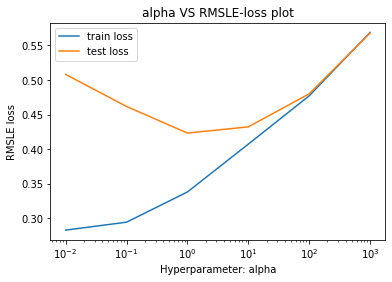

In [17]:
import matplotlib.pyplot as plt
plt.plot(alpha_list, train_loss, label='train loss')
plt.plot(alpha_list, test_loss, label='test loss')
plt.title('alpha VS RMSLE-loss plot')
plt.xlabel('Hyperparameter: alpha')
plt.ylabel('RMSLE loss')
plt.xscale('log')
plt.legend()
plt.show()

##### We can see that the best parameter is alpha = 1

In [64]:
from sklearn.linear_model import Ridge
import time
start_time = time.time()
regressor = Ridge(alpha=1)
regressor.fit(X_tr, y_train_std)
print('time taken (mins):', (time.time()-start_time)/60)

time taken (mins): 3.3548355102539062


In [65]:
from sklearn.metrics import mean_squared_log_error
y_pred = regressor.predict(X_tr)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
loss = np.sqrt(mean_squared_log_error(y_train, y_pred))
print('train loss:', loss)

train loss: 0.33818019998792004


In [66]:
y_pred = regressor.predict(X_cv)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
loss = np.sqrt(mean_squared_log_error(y_cv, y_pred))
print('cv loss:', loss)

cv loss: 0.42328810069779127


In [0]:
y_pred_ridge_normal_tr = regressor.predict(X_tr)
y_pred_ridge_normal_cv = regressor.predict(X_cv)
y_pred_ridge_normal_te = regressor.predict(X_test)

#### Ridge regressor on binary data

In [27]:
from tqdm.notebook import tqdm
from sklearn.linear_model import Ridge
train_loss = []
test_loss = []
alpha_list = [10,100,1000]
for alpha in tqdm(alpha_list):
  regressor = Ridge(alpha=alpha)
  regressor.fit(X_tr_binary, y_train_std)
  # train loss
  y_pred = regressor.predict(X_tr_binary)
  y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
  train_loss.append(np.sqrt(mean_squared_log_error(y_train, y_pred)))
  # test loss
  y_pred = regressor.predict(X_cv_binary)
  y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
  test_loss.append(np.sqrt(mean_squared_log_error(y_cv, y_pred)))

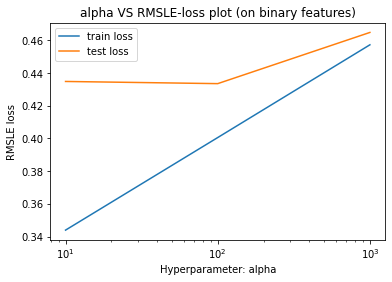

In [29]:
import matplotlib.pyplot as plt
plt.plot(alpha_list, train_loss, label='train loss')
plt.plot(alpha_list, test_loss, label='test loss')
plt.title('alpha VS RMSLE-loss plot (on binary features)')
plt.xlabel('Hyperparameter: alpha')
plt.ylabel('RMSLE loss')
plt.xscale('log')
plt.legend()
plt.show()

In [68]:
from sklearn.linear_model import Ridge
start_time = time.time()
regressor = Ridge(alpha=100)
regressor.fit(X_tr_binary, y_train_std)
print('time taken (mins):', (time.time()-start_time)/60)

time taken (mins): 3.0487144589424133


In [69]:
y_pred = regressor.predict(X_tr_binary)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
loss = np.sqrt(mean_squared_log_error(y_train, y_pred))
print('train loss:', loss)

train loss: 0.4005398755326944


In [70]:
y_pred = regressor.predict(X_cv_binary)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
loss = np.sqrt(mean_squared_log_error(y_cv, y_pred))
print('cv loss:', loss)

cv loss: 0.4335188524794919


In [0]:
y_pred_ridge_binary_tr = regressor.predict(X_tr_binary)
y_pred_ridge_binary_cv = regressor.predict(X_cv_binary)
y_pred_ridge_binary_te = regressor.predict(X_test_binary)

##### We can see that the results obtained using the binary features are kind of similar to that obtained using normal features, infact the normal features yield better results.

#### Let's Try SGD-Regressor (as SVR) on Binary data

In [22]:
# Let's fit the data using Lasso regressor on different values of alpha.
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RandomizedSearchCV
import time

regressor = SGDRegressor()
start_time = time.time()

prams = {'loss':['huber','epsilon_insensitive','squared_epsilon_insensitive'], 'eta0':[10e-4, 10e-5, 10e-6],
         'epsilon':[10e-1,10e-2,10e-3,10e-4], 'max_iter':[1000,2000], 'learning_rate':['invscaling', 'adaptive', 'optimal'],
         'penalty':['l1','l2']}

r_cv = RandomizedSearchCV(regressor, param_distributions=prams, verbose=1, n_jobs=-1, cv=3)
r_cv.fit(X_tr_binary, y_train_std.ravel())
print('Total time taken (mins):',(time.time()-start_time)/60)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 23.3min finished


Total time taken (mins): 24.344847889741263


In [24]:
r_cv.best_params_

{'epsilon': 0.1,
 'eta0': 0.0001,
 'learning_rate': 'adaptive',
 'loss': 'squared_epsilon_insensitive',
 'max_iter': 2000,
 'penalty': 'l2'}

In [87]:
# Using best parameters from randomsearchcv for binary data
from tqdm.notebook import tqdm
from sklearn.linear_model import SGDRegressor
import time
start_time = time.time()
regressor = SGDRegressor(eta0=0.1, epsilon=0.0001, loss='squared_epsilon_insensitive', learning_rate='adaptive',max_iter= 2000)
regressor.fit(X_tr_binary, y_train_std.ravel())
print('time taken (mins):', (time.time()-start_time)/60)

time taken (mins): 3.784726937611898


In [88]:
from sklearn.metrics import mean_squared_log_error
# train loss
y_pred = regressor.predict(X_tr_binary)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
train_loss = np.sqrt(mean_squared_log_error(y_train, y_pred))
# test loss
y_pred = regressor.predict(X_cv_binary)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
cv_loss = np.sqrt(mean_squared_log_error(y_cv, y_pred))
print('train loss for', train_loss)
print('cv loss:', cv_loss)

train loss for 0.3951402710355503
cv loss: 0.4325988392891102


In [0]:
y_pred_sgd_svr_binary_tr = regressor.predict(X_tr_binary)
y_pred_sgd_svr_binary_cv = regressor.predict(X_cv_binary)
y_pred_sgd_svr_binary_te = regressor.predict(X_test_binary)

### Let's try SGD regressor (as linear regressor) on binary data

In [6]:
# Let's fit the data using Lasso regressor on different values of alpha.
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RandomizedSearchCV
import time

regressor = SGDRegressor()
start_time = time.time()

prams = {'loss':['epsilon_insensitive'], 'eta0':[10e-1,10e-2,10e-3,10e-4],
         'epsilon':[0.1,1.0,10,100], 'max_iter':[1000,2000,3000], 'learning_rate':['adaptive'], 'penalty': ['l1','l2']}

r_cv = RandomizedSearchCV(regressor, param_distributions=prams, verbose=1, n_jobs=-1, cv=3)
r_cv.fit(X_tr, y_train_std.ravel())
print('Total time taken (mins):',(time.time()-start_time)/60)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.3min finished
Total time taken (mins): 7.284886125723521


In [7]:
r_cv.best_params_

{'epsilon': 0.1,
 'eta0': 0.001,
 'learning_rate': 'adaptive',
 'loss': 'squared_loss',
 'max_iter': 3000,
 'penalty': 'l2'}


In [49]:
from tqdm.notebook import tqdm
from sklearn.linear_model import SGDRegressor
import time
start_time = time.time()
regressor = SGDRegressor(eta0=0.1,epsilon=0.001,loss='squared_loss', learning_rate='adaptive',max_iter= 3000)
regressor.fit(X_tr_binary, y_train_std.ravel())
print('time taken (mins):', (time.time()-start_time)/60)

time taken (mins): 2.887946359316508


In [51]:
from sklearn.metrics import mean_squared_log_error
# train loss
y_pred = regressor.predict(X_tr_binary)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
train_loss = np.sqrt(mean_squared_log_error(y_train, y_pred))
# test loss
y_pred = regressor.predict(X_cv_binary)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
cv_loss = np.sqrt(mean_squared_log_error(y_cv, y_pred))
print('train loss for', train_loss)
print('cv loss:', cv_loss)

train loss for 0.4085517880460707
cv loss: 0.43622497120374315


In [0]:
y_pred_sgd_lr_binary_tr = regressor.predict(X_tr_binary)
y_pred_sgd_lr_binary_cv = regressor.predict(X_cv_binary)
y_pred_sgd_lr_binary_te = regressor.predict(X_test_binary)

### SVR

##### Note: I've used a LinearSVR instead of sklearn's svm.SVR with 'poly' or 'RBF' kernel because it was taking over 60 mins to yield results, even the SVR(kernel='linear') was taking much longer to fit than LinearSVR

#### SVR on normal data

In [4]:
# Let's fit the data using Linear SVR on different values of C.
# Sklearn.svm.SVR was too slow because the dataset is so large, Could've used the 'poly' and 'rbf' kernel but it was taking too much time.
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_log_error
from sklearn.svm import LinearSVR

train_loss = []
test_loss = []
C = [10, 1, 0.1, 0.01]

for c in tqdm(C):
  regressor = LinearSVR(C=c)
  regressor.fit(X_tr, y_train_std.ravel())
  # train loss
  y_pred = regressor.predict(X_tr)
  y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
  train_loss.append(np.sqrt(mean_squared_log_error(y_train, y_pred)))
  # test loss
  y_pred = regressor.predict(X_cv)
  y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
  test_loss.append(np.sqrt(mean_squared_log_error(y_cv, y_pred)))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


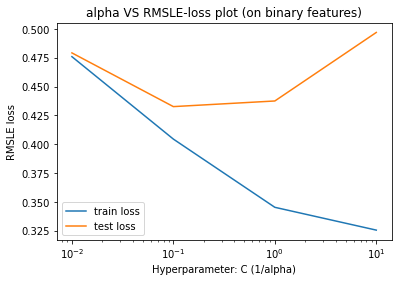

In [5]:
import matplotlib.pyplot as plt
plt.plot(C, train_loss, label='train loss')
plt.plot(C, test_loss, label='test loss')
plt.title('alpha VS RMSLE-loss plot (on binary features)')
plt.xlabel('Hyperparameter: C (1/alpha)')
plt.ylabel('RMSLE loss')
plt.xscale('log')
plt.legend()
plt.show()

In [72]:
# Let's fit the data using linearSVR with C=1.
from tqdm.notebook import tqdm
from sklearn.svm import LinearSVR
import time
start_time = time.time()
regressor = LinearSVR(C=0.1)
regressor.fit(X_tr, y_train_std.ravel())
print('time taken (mins):', (time.time()-start_time)/60)

time taken (mins): 0.8211001515388489


In [73]:
from sklearn.metrics import mean_squared_log_error
# train loss
y_pred = regressor.predict(X_tr)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
train_loss = np.sqrt(mean_squared_log_error(y_train, y_pred))
# test loss
y_pred = regressor.predict(X_cv)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
cv_loss = np.sqrt(mean_squared_log_error(y_cv, y_pred))
print('train loss for', train_loss)
print('cv loss:', cv_loss)

train loss for 0.4044476971653822
cv loss: 0.4326311530651933


In [0]:
y_pred_svr_normal_tr = regressor.predict(X_tr)
y_pred_svr_normal_cv = regressor.predict(X_cv)
y_pred_svr_normal_te = regressor.predict(X_test)

#### SVR on binary data

In [59]:
# Let's fit the data using Linear SVR on different values of C.
# Sklearn.svm.SVR was too slow because the dataset is so large, Could've used the 'poly' and 'rbf' kernel but it was taking too much time.
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_log_error
from sklearn.svm import LinearSVR

train_loss = []
test_loss = []
C = [0.01,0.001,0.0001,0.00001,0.000001]

for c in tqdm(C):
  regressor = LinearSVR(C=c)
  regressor.fit(X_tr_binary, y_train_std.ravel())
  # train loss
  y_pred = regressor.predict(X_tr_binary)
  y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
  train_loss.append(np.sqrt(mean_squared_log_error(y_train, y_pred)))
  # test loss
  y_pred = regressor.predict(X_cv_binary)
  y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
  test_loss.append(np.sqrt(mean_squared_log_error(y_cv, y_pred)))

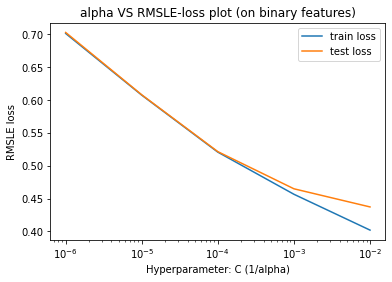

In [60]:
import matplotlib.pyplot as plt
plt.plot(C, train_loss, label='train loss')
plt.plot(C, test_loss, label='test loss')
plt.title('alpha VS RMSLE-loss plot (on binary features)')
plt.xlabel('Hyperparameter: C (1/alpha)')
plt.ylabel('RMSLE loss')
plt.xscale('log')
plt.legend()
plt.show()

In [77]:
# Let's fit the data using linearSVR with C=0.01
from tqdm.notebook import tqdm
from sklearn.svm import LinearSVR
start_time = time.time()
regressor = LinearSVR(C=0.01)
regressor.fit(X_tr_binary, y_train_std.ravel())
print('time taken (mins):', (time.time()-start_time)/60)

time taken (mins): 2.0566370844841004


In [78]:
# train loss
y_pred = regressor.predict(X_tr_binary)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
train_loss = np.sqrt(mean_squared_log_error(y_train, y_pred))
# test loss
y_pred = regressor.predict(X_cv_binary)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
cv_loss = np.sqrt(mean_squared_log_error(y_cv, y_pred))
print('train loss for', train_loss)
print('cv loss:', cv_loss)

train loss for 0.4020747090982833
cv loss: 0.4373317904371579


In [0]:
y_pred_svr_binary_tr = regressor.predict(X_tr_binary)
y_pred_svr_binary_cv = regressor.predict(X_cv_binary)
y_pred_svr_binary_te = regressor.predict(X_test_binary)

In [0]:
# Ridge normal
np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_sgd_lr_binary_tr.npy", y_pred_sgd_lr_binary_tr)
np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_sgd_lr_binary_cv.npy", y_pred_sgd_lr_binary_cv)
np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_sgd_lr_binary_te.npy", y_pred_sgd_lr_binary_te)
# Ridge binary
np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_sgd_svr_binary_tr.npy", y_pred_sgd_svr_binary_tr)
np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_sgd_svr_binary_cv.npy", y_pred_sgd_svr_binary_cv)
np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_sgd_svr_binary_te.npy", y_pred_sgd_svr_binary_te)

In [0]:
# import numpy as np
# # Ridge normal
# np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_ridge_normal_tr.npy", y_pred_ridge_normal_tr)
# np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_ridge_normal_cv.npy", y_pred_ridge_normal_cv)
# np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_ridge_normal_te.npy", y_pred_ridge_normal_te)
# # Ridge binary
# np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_ridge_binary_tr.npy", y_pred_ridge_binary_tr)
# np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_ridge_binary_cv.npy", y_pred_ridge_binary_cv)
# np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_ridge_binary_te.npy", y_pred_ridge_binary_te)
# # SVR normal
# np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_svr_normal_tr.npy", y_pred_svr_normal_tr)
# np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_svr_normal_cv.npy", y_pred_svr_normal_cv)
# np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_svr_normal_te.npy", y_pred_svr_normal_te)
# # SVR binary
# np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_svr_binary_tr.npy", y_pred_svr_binary_tr)
# np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_svr_binary_cv.npy", y_pred_svr_binary_cv)
# np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_svr_binary_te.npy", y_pred_svr_binary_te)
# # SGD-lr binary
# np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_sgd_lr_binary_tr.npy", y_pred_sgd_lr_binary_tr)
# np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_sgd_lr_binary_cv.npy", y_pred_sgd_lr_binary_cv)
# np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_sgd_lr_binary_te.npy", y_pred_sgd_lr_binary_te)
# # SGD-svr binary
# np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_sgd_svr_binary_tr.npy", y_pred_sgd_svr_binary_tr)
# np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_sgd_svr_binary_cv.npy", y_pred_sgd_svr_binary_cv)
# np.save("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_sgd_svr_binary_te.npy", y_pred_sgd_svr_binary_te)

In [0]:
# import numpy as np
# # Ridge normal
# y_pred_ridge_normal_tr = np.load("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_ridge_normal_tr.npy")
# y_pred_ridge_normal_cv = np.load("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_ridge_normal_cv.npy")
# y_pred_ridge_normal_te = np.load("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_ridge_normal_te.npy")
# # Ridge binary
# y_pred_ridge_binary_tr = np.load("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_ridge_binary_tr.npy")
# y_pred_ridge_binary_cv = np.load("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_ridge_binary_cv.npy")
# y_pred_ridge_binary_te = np.load("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_ridge_binary_te.npy")
# # SVR normal
# y_pred_svr_normal_tr = np.load("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_svr_normal_tr.npy")
# y_pred_svr_normal_cv = np.load("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_svr_normal_cv.npy")
# y_pred_svr_normal_te = np.load("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_svr_normal_te.npy")
# # SVR binary
# y_pred_svr_binary_tr = np.load("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_svr_binary_tr.npy")
# y_pred_svr_binary_cv = np.load("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_svr_binary_cv.npy")
# y_pred_svr_binary_te = np.load("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_svr_binary_te.npy")
# # SGD-lr binary
# y_pred_sgd_lr_binary_tr = np.load("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_sgd_lr_binary_tr.npy")
# y_pred_sgd_lr_binary_cv = np.load("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_sgd_lr_binary_cv.npy")
# y_pred_sgd_lr_binary_te = np.load("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_sgd_lr_binary_te.npy")
# # SGD-svr binary
# y_pred_sgd_svr_binary_tr = np.load("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_sgd_svr_binary_tr.npy")
# y_pred_sgd_svr_binary_cv = np.load("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_sgd_svr_binary_cv.npy")
# y_pred_sgd_svr_binary_te = np.load("drive/My Drive/marcari_kaggle_data/sparse_data/ensemble_data/y_pred_sgd_svr_binary_te.npy")

### The tree based models below were taking too much time to fit (more than 60 mins) so I reduced the features using Ridge regressor on binary data.

#### Selecting top features for tree based models

##### Note: Other dimensionality technique that I tried was truncated-SVD but it required a lot of RAM for computation, the system kept crashing with only 1000 dimension transformation.

In [0]:
from sklearn.feature_selection import SelectFromModel
# from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
regressor = Ridge(alpha=100)
selection = SelectFromModel(regressor)
selection.fit(X_tr_binary, y_train_std.ravel())

In [0]:
X_train_top = selection.transform(X_tr_binary)
X_cv_top = selection.transform(X_cv_binary)
X_test_top = selection.transform(X_test_binary)

In [83]:
X_train_top.shape, X_cv_top.shape

((1407577, 245290), (74084, 245290))

##### Note: The hyperparameter-tuning methods may not be upto the mark as I've not used k-fold technique or experimented with too many hyperparameters, because this was a kernel challenge and the complete code was supposed to be executed under 60 mins with only 16 GB RAM. Since the tree based methods were taking too much time to train to yield a decent score, I did not focus much into hyperparameter tuning as the only option to get a good score was to increase the hyperparameter values and that was taking over 60 mins to calculate.

#### Random forest - (max_depth=3, n_estimators=100)

In [0]:
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
import time

regressor = RandomForestRegressor(n_estimators=100, max_depth=3)
start_time = time.time()

regressor.fit(X_train_top, y_train_std.ravel())
print('Total time taken (mins):',(time.time()-start_time)/60)

Total time taken (mins): 22.684882108370463


In [0]:
y_pred = regressor.predict(X_train_top)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
loss = np.sqrt(mean_squared_log_error(y_train, y_pred))
print('train loss:', loss)

train loss: 0.714995490935859


In [0]:
y_pred = regressor.predict(X_cv_top)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
loss = np.sqrt(mean_squared_log_error(y_cv, y_pred))
print('cv loss:', loss)

cv loss: 0.7159384810533365


#### Random forest - (max_depth=4, n_estimators=200)

In [122]:
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
import time

regressor = RandomForestRegressor(n_estimators=200, max_depth=4)
start_time = time.time()

regressor.fit(X_train_top, y_train_std.ravel())
print('Total time taken (mins):', (time.time()-start_time)/60)

Total time taken (mins): 65.27256505886713


In [0]:
y_pred = regressor.predict(X_train_top)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
loss = np.sqrt(mean_squared_log_error(y_train, y_pred))
print('train loss:', loss)

train loss: 0.704861632459936


In [0]:
y_pred = regressor.predict(X_cv_top)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
loss = np.sqrt(mean_squared_log_error(y_cv, y_pred))
print('cv loss:', loss)

cv loss: 0.7061159730308902


#### Decision Tree

In [0]:
# Let's fit the data using Lasso regressor on different values of alpha.
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
import time

regressor = DecisionTreeRegressor()
start_time = time.time()
prams = {'min_samples_split':[16,32,48,64],
         'max_depth':[16,32,48,64]}

r_cv = RandomizedSearchCV(regressor, param_distributions=prams, verbose=1, n_jobs=-1, cv=3, return_train_score=True)
r_cv.fit(X_train_top, y_train_std.ravel())
print('Total time taken (mins):',(time.time()-start_time)/60)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 273.8min finished


Total time taken (mins): 315.2141575098038


In [0]:
r_cv.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=64,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=64,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [0]:
# Let's fit the data using Lasso regressor on different values of alpha.
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
import time

regressor = DecisionTreeRegressor(max_depth=32, min_samples_split=64)
start_time = time.time()

regressor.fit(X_train_top, y_train_std.ravel())
print('Total time taken (mins):',(time.time()-start_time)/60)

Total time taken (mins): 14.004970304171245


In [0]:
y_pred = regressor.predict(X_train_top)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
loss = np.sqrt(mean_squared_log_error(y_train, y_pred))
print('train loss:', loss)

train loss: 0.5551215677262981


In [0]:
y_pred = regressor.predict(X_cv_top)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
loss = np.sqrt(mean_squared_log_error(y_cv, y_pred))
print('cv loss:', loss)

cv loss: 0.5822795993070736


#### XGBoost - (max_depth=4, n_estimators=200)

In [8]:
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import time

start_time = time.time()
regressor = XGBRegressor(n_jobs=-1, reg='squarederror', max_depth=4, n_estimators=200)
regressor.fit(X_train_top, y_train_std.ravel())
print('Total time taken (mins):',(time.time()-start_time)/60)

[08:47:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total time taken (mins): 27.367798594633737


In [0]:
y_pred = regressor.predict(X_train_top)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
loss = np.sqrt(mean_squared_log_error(y_train, y_pred))
print('train loss:', loss)

train loss: 0.5753948869097049


In [0]:
y_pred = regressor.predict(X_cv_top)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
loss = np.sqrt(mean_squared_log_error(y_cv, y_pred))
print('cv loss:', loss)

cv loss: 0.5766885688973504


#### XGBoost - (max_depth=6, n_estimators=500)

In [0]:
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import time

start_time = time.time()
regressor = XGBRegressor(n_jobs=-1, reg='squarederror', max_depth=6, n_estimators=500)
regressor.fit(X_train_top, y_train_std.ravel())
print('Total time taken (mins):',(time.time()-start_time)/60)

Total time taken (mins): 78.76666711568832
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg='squarederror', reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)


In [0]:
y_pred = regressor.predict(X_train_top)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
loss = np.sqrt(mean_squared_log_error(y_train, y_pred))
print('train loss:', loss)

train loss: 0.5098266581049882


In [0]:
y_pred = regressor.predict(X_cv_top)
y_pred = np.expm1(y_scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
loss = np.sqrt(mean_squared_log_error(y_cv, y_pred))
print('cv loss:', loss)

cv loss: 0.517337936086279


##### We can see that the loss decrease as we increase the max_depth and n_estimators but it takes too long to train (around 78 mins).
##### And this is after selecting the top features, it'll certainly take more time to train if all the features are included.

### Comparing different models and their performance

In [8]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["model","data","best hyperparameters","train loss","cv loss","time taken(mins)"]

x.add_row(['Ridge', 'normal', 'alpha=1', 0.33818019998792004, 0.42328810069779127, 3.209493120511373])
x.add_row(['Ridge', 'binary', 'alpha=100', 0.4005398755326944, 0.4335188524794919, 2.8726065436999004])
x.add_row(['LinearSVR', 'normal', 'C=0.1', 0.4044476971653822, 0.4326311530651933, 0.8211001515388489])
x.add_row(['LinearSVR', 'binary', 'C=0.01', 0.4020747090982833, 0.4373317904371579, 2.0566370844841004])
x.add_row(['SGDRegressor\n(as SVR)', 'binary', "epsilon: 0.0001, eta0: 0.1, learning_rate: 'adaptive',\nloss: 'epsilon_insensitive',max_iter: 2000", 0.3951402710355503, 0.4325988392891102, 3.784726937611898])
x.add_row(['SGDRegressor\n(as LR)', 'binary', "eta0=0.1, epsilon=0.001, loss='squared_loss',\nlearning_rate='adaptive',max_iter= 3000", 0.4085517880460707, 0.43622497120374315, 2.887946359316508])
x.add_row(['RandomForestRegressor', 'top selected binary', 'n_estimators=100, max_depth=3', 0.714995490935859, 0.7159384810533365, 22.684882108370463])
x.add_row(['RandomForestRegressor', 'top selected binary', 'n_estimators=200, max_depth=4', 0.704861632459936, 0.7061159730308902, 65.27256505886713])
x.add_row(['DecisionTreeRegressor', 'top selected binary', 'max_depth=32, min_samples_split=64', 0.5551215677262981, 0.5822795993070736, 14.004970304171245])
x.add_row(['XGBRegressor', 'top selected binary', 'max_depth=4, n_estimators=200', 0.5753948869097049, 0.5766885688973504, 27.367798594633737])
x.add_row(['XGBRegressor', 'top selected binary', 'max_depth=6, n_estimators=500', 0.5098266581049882, 0.517337936086279, 78.76666711568832])

print(x)

+-----------------------+---------------------+--------------------------------------------------------+---------------------+---------------------+--------------------+
|         model         |         data        |                  best hyperparameters                  |      train loss     |       cv loss       |  time taken(mins)  |
+-----------------------+---------------------+--------------------------------------------------------+---------------------+---------------------+--------------------+
|         Ridge         |        normal       |                        alpha=1                         | 0.33818019998792004 | 0.42328810069779127 | 3.209493120511373  |
|         Ridge         |        binary       |                       alpha=100                        |  0.4005398755326944 |  0.4335188524794919 | 2.8726065436999004 |
|       LinearSVR       |        normal       |                         C=0.1                          |  0.4044476971653822 |  0.4326311530651933 | 0

#### In the above table we can see that the tree based models are taking too much time to compute, infact the data I'm using for tree based is much smaller, I'm using top selected binary features from Ridge regressor. So the new data has only around 236k features instead of the original 700k that other linear models are trained on.
### The Linear models have out performed other models so I'll be using these to create an Ensemble.

#### I've taken the mean of predicted values of Ridge and linearSVM model on normal and binary data.

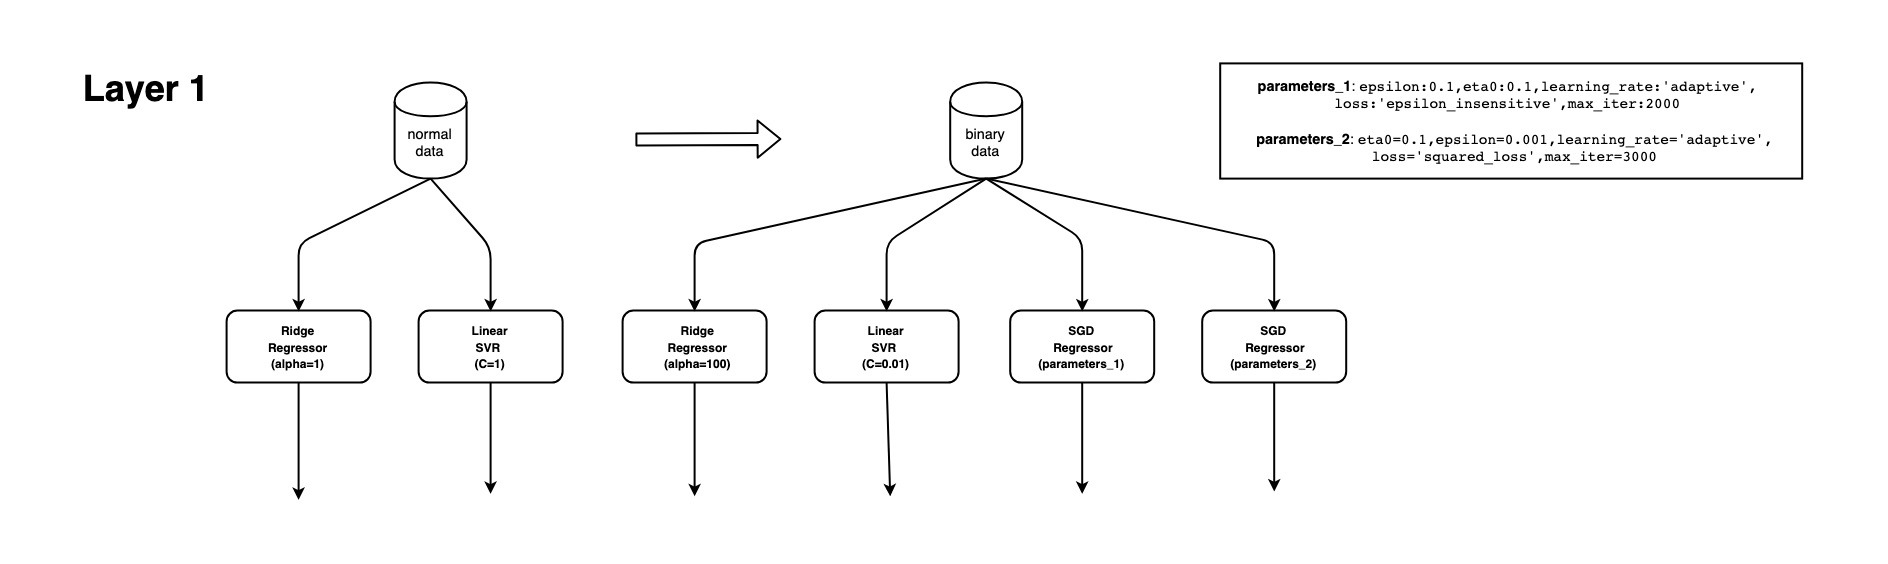

In [12]:
%matplotlib inline
from IPython.display import Image
Image('layer_1.png', width=1600, height=400)